# **Baseline model**

### **Descripción**

Crearemos un modelo de referencia utilizando un enfoque heurístico. El modelo se basará en el análisis de datos de este notebook

Basándome en la heurística propuesta en el EDA, sólo se necesitan 6 columnas: **"PhoneService", "MultipleLines", "InternetService", "Contract", "SeniorCitizen" y "PaymentMethod".**

Y agregaré dos reglas más debido a la alta relación de estas dos variables con no hacer Churn: **"tenure"y "MonthlyCharges"**

📚 **Import libraries**

In [1]:
# base libraries for data science
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.pipeline import Pipeline

💾 **Cargamos los datos**

In [2]:
# configuración para que solo se muestren 2 decimales
pd.set_option("display.float_format", "{:.2f}".format)

BASE_DIR = Path("/home/lof/Projects/Telco-Customer-Churn")
DATA_DIR = BASE_DIR / "data" / "interim"
churn_df = pd.read_parquet(
    DATA_DIR / "churn_type_fixed.parquet", engine="pyarrow")

👷 **Data preparation**

In [3]:
cols_boolean = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
churn_df[cols_boolean] = churn_df[cols_boolean].astype("category")
cols_categoric = ['StreamingMovies', 'InternetService',
       'StreamingTV', 'OnlineSecurity', 'MultipleLines',
       'DeviceProtection', 'TechSupport', 'gender ', 'OnlineBackup', 'PaymentMethod',
       'Contract']
churn_df[cols_categoric] = churn_df[cols_categoric].astype("category")

churn_df.drop_duplicates(inplace=True, keep="first")

In [4]:
selected_features = ["PhoneService", "MultipleLines", "InternetService", "Contract", "SeniorCitizen" , 
                     "PaymentMethod", "Churn", "tenure", "MonthlyCharges"]

churn_features = churn_df[selected_features]

churn_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6917 entries, 0 to 11361
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   PhoneService     6841 non-null   category
 1   MultipleLines    6825 non-null   category
 2   InternetService  6804 non-null   category
 3   Contract         6833 non-null   category
 4   SeniorCitizen    6891 non-null   category
 5   PaymentMethod    6832 non-null   category
 6   Churn            6866 non-null   category
 7   tenure           6856 non-null   float64 
 8   MonthlyCharges   6841 non-null   float64 
dtypes: category(7), float64(2)
memory usage: 210.4 KB


In [5]:
churn_features.isna().sum()

PhoneService        76
MultipleLines       92
InternetService    113
Contract            84
SeniorCitizen       26
PaymentMethod       85
Churn               51
tenure              61
MonthlyCharges      76
dtype: int64

Eliminar los duplicados, si los hay en el dataset, es importante para evitar cualquier sesgo en el conjunto de datos o data leakage cuando se entrena un modelo de aprendizaje automático con los datos.

Pero para un modelo heurístico, los duplicados no afectan al modelo.

In [6]:
len(churn_features.drop_duplicates())


6758

Después de seleccionar sólo 8 columnas hay un montón de duplicados, luego, más columnas se seleccionan y la probabilidad de duplicados es menor.

In [7]:
churn_features.sample(10, random_state=42)

,PhoneService,MultipleLines,InternetService,Contract,SeniorCitizen,PaymentMethod,Churn,tenure,MonthlyCharges
557,1.00,Yes,Fiber optic,Month-to-month,0.00,Electronic check,1.00,30.00,94.40
6938,1.00,No,Fiber optic,Month-to-month,0.00,Credit card (automatic),0.00,5.00,69.95
6020,1.00,No,No,Month-to-month,0.00,Mailed check,1.00,9.00,20.25
3170,1.00,Yes,Fiber optic,Month-to-month,0.00,Bank transfer (automatic),1.00,48.00,107.40
7947,1.00,Yes,Fiber optic,Month-to-month,0.00,Credit card (automatic),0.00,34.00,90.05
4947,1.00,No,No,One year,0.00,Credit card (automatic),0.00,61.00,19.10
4304,0.00,No phone service,DSL,Month-to-month,0.00,Mailed check,0.00,1.00,35.90
4854,1.00,No,DSL,Month-to-month,0.00,Mailed check,0.00,6.00,45.65
6141,1.00,No,No,Two year,0.00,Bank transfer (automatic),0.00,69.00,19.75
444,1.00,Yes,Fiber optic,Month-to-month,1.00,Bank transfer (automatic),0.00,35.00,102.05


👨‍🏭 **Feature Engineering**

In [8]:
cols_numeric = ["tenure", "MonthlyCharges"]
cols_categoric = ["PhoneService", "MultipleLines", "InternetService", "Contract", "SeniorCitizen" , "PaymentMethod"]

In [ ]:
def replace_out_of_range_values(X: pd.DataFrame) -> pd.DataFrame:
    """
    Reemplaza valores fuera de rango en las columnas 'MonthlyCharges' y 'TotalCharges' con np.nan.
    """
    assert isinstance(X, pd.DataFrame)
    mask = ~((X["MonthlyCharges"] > 0) & (X["MonthlyCharges"] < 500))
    X.loc[mask, "MonthlyCharges"] = np.nan
    return X


def replace_invalid_values(X: pd.DataFrame) -> pd.DataFrame:
    """
    Reemplaza valores incorrectos en columnas específicas con np.nan y convierte ciertas columnas a tipo 'category'.
    """
    assert isinstance(X, pd.DataFrame)
    
    # Reemplazar valores inválidos
    invalid_values = {
        "StreamingTV": "5412335",
        "StreamingMovies": "1523434",
        "MultipleLines": "1244132",
        "DeviceProtection": "1243524"
    }
    X.replace(invalid_values, np.nan, inplace=True)
    
    # Definir columnas a convertir a tipo 'category'
    cols_boolean = ['SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
    cols_categoric = ['StreamingMovies', 'InternetService', 'StreamingTV', 'OnlineSecurity', 'MultipleLines',
                      'DeviceProtection', 'TechSupport', 'gender', 'OnlineBackup', 'PaymentMethod', 'Contract']
    
    # Convertir a tipo 'category' solo si existen en el DataFrame
    existing_cols_boolean = [col for col in cols_boolean if col in X.columns]
    existing_cols_categoric = [col for col in cols_categoric if col in X.columns]
    
    X[existing_cols_boolean] = X[existing_cols_boolean].astype('category')
    X[existing_cols_categoric] = X[existing_cols_categoric].astype('category')
    
    return X

In [10]:
from sklearn.impute import KNNImputer
from sklearn.pipeline import FunctionTransformer

# Para esta heuristica no se necesita escalar las variables numericas
# Tampoco se neecesita codificar las variables categoricas con el onehot encoder
# Se crean dos pipelines, uno para las variables numericas y otro para las categoricas
numeric_pipe = Pipeline(
    steps=[
        ("outlier_removal", FunctionTransformer(replace_out_of_range_values, validate=False)),
        ("imputer", KNNImputer(n_neighbors=5))
    ]
)

categorical_pipe = Pipeline(
    steps=[
        ("clean_categories", FunctionTransformer(replace_invalid_values, validate=False)),
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)



preprocessor = ColumnTransformer(
    transformers=[
        ("numericas", numeric_pipe, cols_numeric),
        ("categoricas nominales", categorical_pipe, cols_categoric),
    ]
)

In [11]:
preprocessor

ColumnTransformer(transformers=[('numericas',
                                 Pipeline(steps=[('outlier_removal',
                                                  FunctionTransformer(func=<function replace_out_of_range_values at 0x7f359bae11c0>)),
                                                 ('imputer', KNNImputer())]),
                                 ['tenure', 'MonthlyCharges']),
                                ('categoricas nominales',
                                 Pipeline(steps=[('clean_categories',
                                                  FunctionTransformer(func=<function replace_invalid_values at 0x7f359bae1260>)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['PhoneService', 'MultipleLines',
                                  'InternetService', 'Contract',
                                  'SeniorCitizen', 'PaymentMethod'])])

**Ejemplo de data preprocessing**

In [12]:
data_example = churn_features.drop(columns="Churn").sample(10, random_state=42)
data_example

,PhoneService,MultipleLines,InternetService,Contract,SeniorCitizen,PaymentMethod,tenure,MonthlyCharges
557,1.00,Yes,Fiber optic,Month-to-month,0.00,Electronic check,30.00,94.40
6938,1.00,No,Fiber optic,Month-to-month,0.00,Credit card (automatic),5.00,69.95
6020,1.00,No,No,Month-to-month,0.00,Mailed check,9.00,20.25
3170,1.00,Yes,Fiber optic,Month-to-month,0.00,Bank transfer (automatic),48.00,107.40
7947,1.00,Yes,Fiber optic,Month-to-month,0.00,Credit card (automatic),34.00,90.05
4947,1.00,No,No,One year,0.00,Credit card (automatic),61.00,19.10
4304,0.00,No phone service,DSL,Month-to-month,0.00,Mailed check,1.00,35.90
4854,1.00,No,DSL,Month-to-month,0.00,Mailed check,6.00,45.65
6141,1.00,No,No,Two year,0.00,Bank transfer (automatic),69.00,19.75
444,1.00,Yes,Fiber optic,Month-to-month,1.00,Bank transfer (automatic),35.00,102.05


In [13]:
preprocessor.fit_transform(data_example)

/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X.replace(invalid_values, np.nan, inplace=True)


array([[30.0, 94.4, 1.0, 'Yes', 'Fiber optic', 'Month-to-month', 0.0,
        'Electronic check'],
       [5.0, 69.95, 1.0, 'No', 'Fiber optic', 'Month-to-month', 0.0,
        'Credit card (automatic)'],
       [9.0, 20.25, 1.0, 'No', 'No', 'Month-to-month', 0.0,
        'Mailed check'],
       [48.0, 107.4, 1.0, 'Yes', 'Fiber optic', 'Month-to-month', 0.0,
        'Bank transfer (automatic)'],
       [34.0, 90.05, 1.0, 'Yes', 'Fiber optic', 'Month-to-month', 0.0,
        'Credit card (automatic)'],
       [61.0, 19.1, 1.0, 'No', 'No', 'One year', 0.0,
        'Credit card (automatic)'],
       [1.0, 35.9, 0.0, 'No phone service', 'DSL', 'Month-to-month', 0.0,
        'Mailed check'],
       [6.0, 45.65, 1.0, 'No', 'DSL', 'Month-to-month', 0.0,
        'Mailed check'],
       [69.0, 19.75, 1.0, 'No', 'No', 'Two year', 0.0,
        'Bank transfer (automatic)'],
       [35.0, 102.05, 1.0, 'Yes', 'Fiber optic', 'Month-to-month', 1.0,
        'Bank transfer (automatic)']], dtype=object)

**Train / Test split**

In [14]:
churn_features = churn_features.dropna(subset=["Churn"])
churn_features['Churn'] = churn_features['Churn'].astype(int)
X_features = churn_features.drop(columns=["Churn"])
Y_target = churn_features["Churn"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

In [15]:
x_train.shape, y_train.shape

((5492, 8), (5492,))

In [16]:
x_test.shape, y_test.shape

((1374, 8), (1374,))

**Modelo heuristico**

In [17]:
class HeuristicModel(BaseEstimator, ClassifierMixin):
    """Modelo heurístico para predecir el churn"""

    def fit(self, X, y=None):
        if y is not None:
            self.classes_ = np.unique(y)
        return self

    def predict(self, X):
        predictions = []
        for row in X:  # Iterar sobre cada fila de X
            phone_service, multiple_lines, internet_service, contract, senior_citizen, payment_method, monthly_charges, tenure = row
            
            if (
                (phone_service == 1)
                and (multiple_lines == "No")
                and (internet_service in ["DSL", "No"])
                and (contract in ["One year", "Two year"])
                and (senior_citizen == 0)
                and (payment_method != "Electronic check")
                and not (20 <= monthly_charges <= 30)  # Nueva condición
                and not (tenure > 40)  # Nueva condición
            ):
                predictions.append(0)
            else:
                predictions.append(1)
        
        return np.array(predictions)

In [18]:
# Model
model = HeuristicModel()

# Evaluation metrics
scoring_metrics = ["accuracy", "f1", "precision", "recall"]

# KFold for the cross-validation
kfold = KFold(n_splits=10)

# Model pipeline = preprocessor + model
model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Variable to store the results of the cross-validation
cv_results = {}
train_results = {}


In [19]:
# Cross-validation evaluation for each metric
for metric in scoring_metrics:
    cv_results[metric] = cross_val_score(
        model_pipe, x_train, y_train, cv=kfold, scoring=metric
    )
    # Evaluate on the training set
    model_pipe.fit(x_train, y_train)
    train_results[metric] = model_pipe.score(x_train, y_train)

# Convert results into a pandas DataFrame
cv_results_df = pd.DataFrame(cv_results)

/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X.replace(invalid_values, np.nan, inplace=True)
/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X.replace(invalid_values, np.nan, inplace=True)


/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X.replace(invalid_values, np.nan, inplace=True)
/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X.replace(invalid_values, np.nan, inplace=True)
/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X.re

accuracy - CV mean: 0.2632945851962245, CV std: 0.016495226245710436
accuracy - Train score: 0.263292061179898
f1 - CV mean: 0.41659672096759753, CV std: 0.020532600777684235
f1 - Train score: 0.263292061179898
precision - CV mean: 0.2632945851962245, CV std: 0.016495226245710436
precision - Train score: 0.263292061179898
recall - CV mean: 1.0, CV std: 0.0
recall - Train score: 0.263292061179898


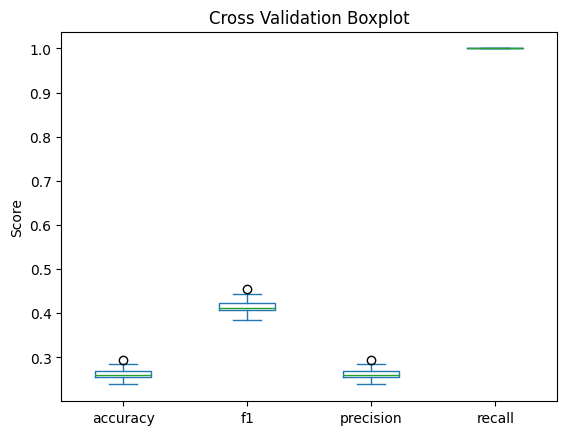

In [20]:
# Print the mean and standard deviation for each metric
for metric_name in scoring_metrics:
    print(
        f"{metric_name} - CV mean: {cv_results_df[metric_name].mean()}, "
        f"CV std: {cv_results_df[metric_name].std()}"
    )
    print(f"{metric_name} - Train score: {train_results[metric_name]}")

# Create a boxplot for the cross-validation results of each metric
cv_results_df.plot.box(title="Cross Validation Boxplot", ylabel="Score");

<Axes: title={'center': 'Training vs Cross-Validation Scores'}, xlabel='Metric', ylabel='Score'>

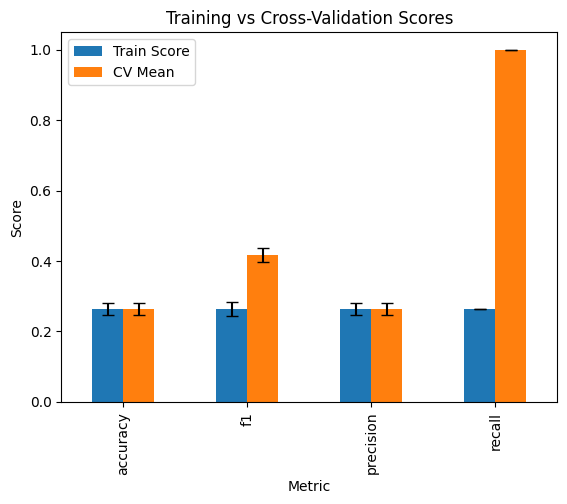

In [21]:
metrics_df = pd.DataFrame(
    {
        "Metric": scoring_metrics,
        "Train Score": [train_results[metric] for metric in scoring_metrics],
        "CV Mean": [cv_results_df[metric].mean() for metric in scoring_metrics],
        "CV Std": [cv_results_df[metric].std() for metric in scoring_metrics],
    }
)

# Create a bar plot for the training and cross-validation metrics
metrics_df.plot(
    kind="bar",
    x="Metric",
    y=["Train Score", "CV Mean"],
    yerr="CV Std",
    title="Training vs Cross-Validation Scores",
    ylabel="Score",
    capsize=4,
)

**Evaluación final**

In [22]:
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    classification_report
)
y_pred = model_pipe.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1012
           1       0.26      1.00      0.42       362

    accuracy                           0.26      1374
   macro avg       0.13      0.50      0.21      1374
weighted avg       0.07      0.26      0.11      1374



/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  X.replace(invalid_values, np.nan, inplace=True)
/home/lof/Projects/Telco-Customer-Churn/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/lof/Projects/Telco-Customer-Churn/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

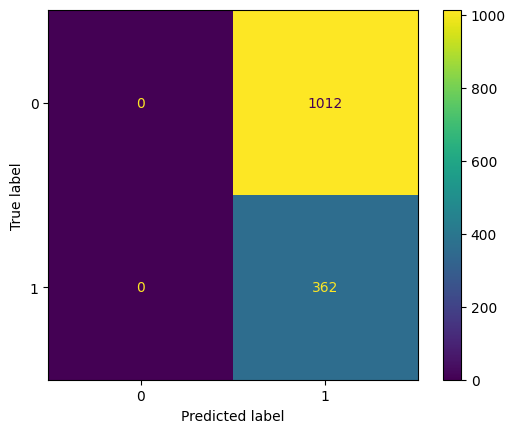

In [23]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

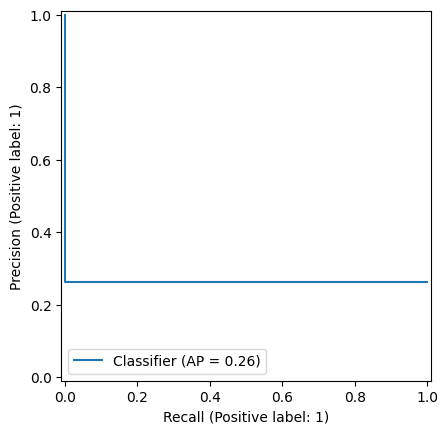

In [24]:
PrecisionRecallDisplay.from_predictions(y_test, y_pred)

/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
/tmp/ipykernel_140824/237267147.py:24: FutureWarning: The behavior of Series.replace (and DataFrame.replac

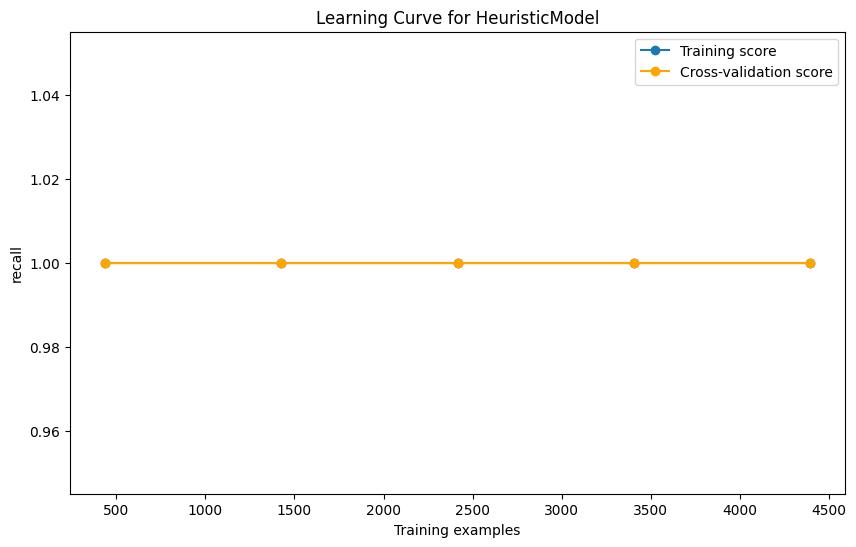

Training Sizes: [ 439 1427 2416 3404 4393]
Training Scores Mean: [1. 1. 1. 1. 1.]
Training Scores Std: [0. 0. 0. 0. 0.]
Test Scores Mean: [1. 1. 1. 1. 1.]
Test Scores Std: [0. 0. 0. 0. 0.]


In [25]:
# Define pipeline = preprocessor + model
model = HeuristicModel()
model_pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])

# Parameters for the learning curve
common_params = {
    "X": x_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=123),
    "n_jobs": -1,
    "return_times": True,
}

scoring_metric = "recall"

# Obtain the learning curve values including fit and score times
train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(
    model_pipe, **common_params, scoring=scoring_metric
)

# Calculate the mean and standard deviation of the scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Calculate the mean and standard deviation of the fit and score times
fit_times_mean = np.mean(fit_times, axis=1)
fit_times_std = np.std(fit_times, axis=1)
score_times_mean = np.mean(score_times, axis=1)
score_times_std = np.std(score_times, axis=1)

# Plot the learning curve
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)
ax.plot(train_sizes, train_mean, "o-", label="Training score")
ax.plot(train_sizes, test_mean, "o-", color="orange", label="Cross-validation score")
ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.3)
ax.fill_between(
    train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.3, color="orange"
)

# Configure the title and labels
ax.set_title(f"Learning Curve for {model.__class__.__name__}")
ax.set_xlabel("Training examples")
ax.set_ylabel(scoring_metric)
ax.legend(loc="best")

# Show the plot
plt.show()

# Print the values for analysis
print("Training Sizes:", train_sizes)
print("Training Scores Mean:", train_mean)
print("Training Scores Std:", train_std)
print("Test Scores Mean:", test_mean)
print("Test Scores Std:", test_std)


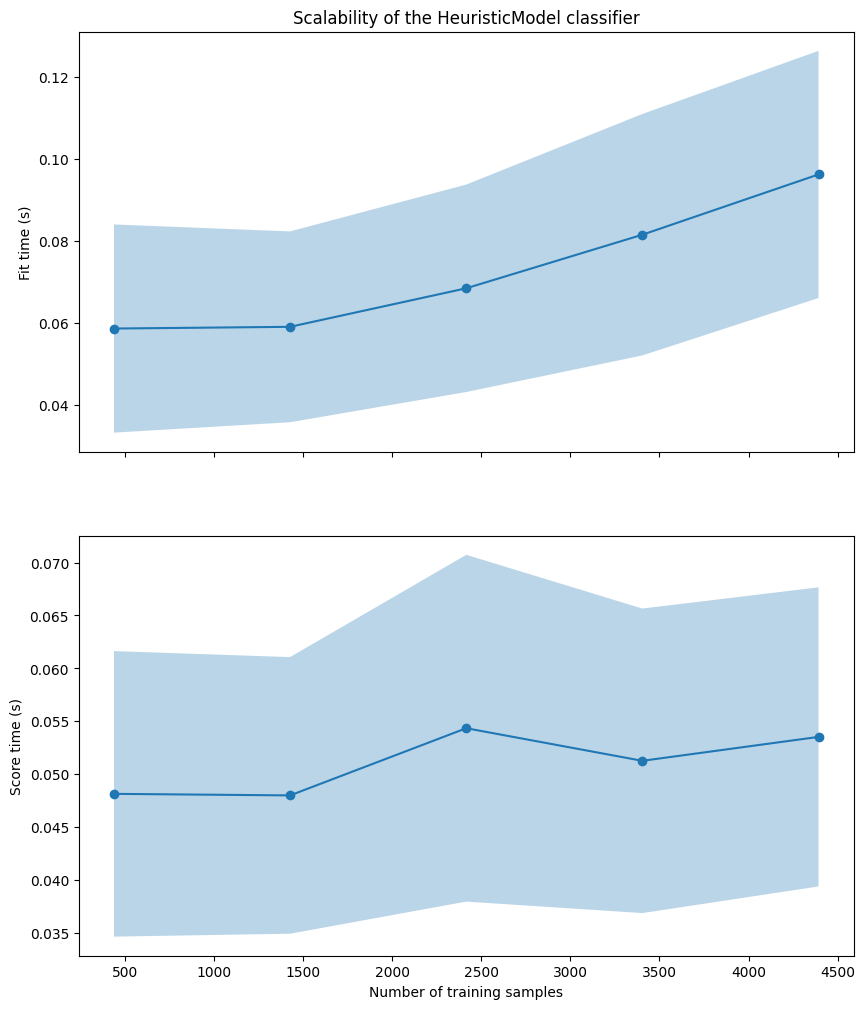

Fit Times Mean: [0.05871698 0.05913624 0.0685383  0.08159857 0.09630782]
Fit Times Std: [0.0253883  0.02327385 0.02530005 0.02944481 0.03015007]
Score Times Mean: [0.0481517  0.04800518 0.0543511  0.05127272 0.05353137]
Score Times Std: [0.01348485 0.01306353 0.01637777 0.01438201 0.01412422]


In [26]:
# Plot the scalability regarding fit time and score time
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 12), sharex=True)

# Scalability regarding the fit time
ax[0].plot(train_sizes, fit_times_mean, "o-")
ax[0].fill_between(
    train_sizes,
    fit_times_mean - fit_times_std,
    fit_times_mean + fit_times_std,
    alpha=0.3,
)
ax[0].set_ylabel("Fit time (s)")
ax[0].set_title(f"Scalability of the {model.__class__.__name__} classifier")

# Scalability regarding the score time
ax[1].plot(train_sizes, score_times_mean, "o-")
ax[1].fill_between(
    train_sizes,
    score_times_mean - score_times_std,
    score_times_mean + score_times_std,
    alpha=0.3,
)
ax[1].set_ylabel("Score time (s)")
ax[1].set_xlabel("Number of training samples")

# Show the plot
plt.show()

# Print the fit and score times for analysis
print("Fit Times Mean:", fit_times_mean)
print("Fit Times Std:", fit_times_std)
print("Score Times Mean:", score_times_mean)
print("Score Times Std:", score_times_std)
